In [4]:
from datasets import load_dataset

dataset = load_dataset('data/gazeta', revision="v1.0")["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [20]:
import jsonlines
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []

    with jsonlines.open(file_name, "r") as reader:
        for line in reader:
            records.append(line)

    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle(records)

    return records

In [21]:
core = 'data/gazeta/'
test_records = read_gazeta_records(f'{core}gazeta_test.jsonl')
train_records = read_gazeta_records(f'{core}gazeta_train.jsonl')
val_records = read_gazeta_records(f'{core}gazeta_val.jsonl')

In [22]:
test_records[2]

{'url': 'https://www.gazeta.ru/social/2019/11/27/12834044.shtml',
 'text': 'В Приморье по подозрению в убийстве 17-летней жительницы поселка Кировский задержан 24-летний мужчина. Об этом сообщили в управлении регионального Следственного комитета. По данным ведомства, о пропаже девушки стало известно 22 ноября 2019 года. Родители обратились с заявлением в правоохранительные органы — ее искали сотрудники полиции , волонтеры и местные жители. Как удалось выяснить сайту kp.ru, 17-летняя россиянка не вернулась после прогулки со своим приятелем. Известно, что вместе с еще одним другом они сидели в местном баре. Когда родственники связались с предполагаемым злоумышленником, с которым перед пропажей виделась девушка, молодой человек заявил родителям, что высадил девушку у магазина, однако о ее дальнейшей судьбе ему ничего неизвестно. Уже 25 ноября тело пропавшей было найдено в реке Уссури. «Наш родственник и его друг на лодке обследовали береговую линию Уссури. Там, примерно в 4 часа и нашли. 

In [24]:
train_records[1].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [25]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


In [27]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()

    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [28]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  83571
Train texts lemma vocabulary size:  38027
Train summaries vocabulary size:  15353
Train summaries lemma vocabulary size:  9006
Train common lemmas summary vs text:  8668


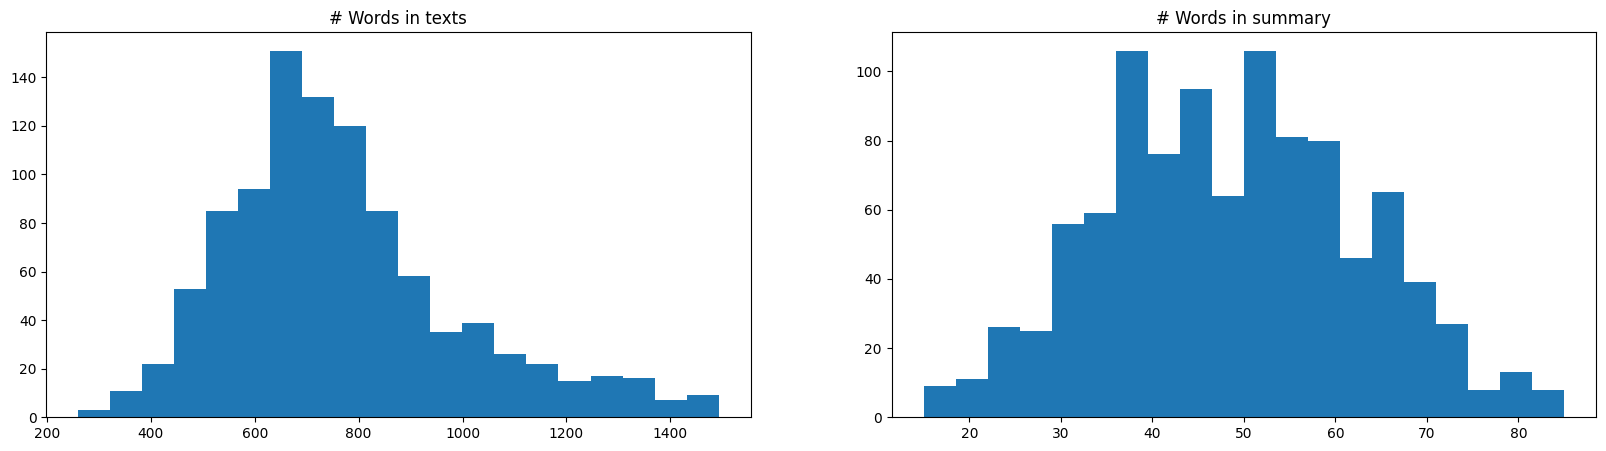

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

In [30]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [31]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: пропавшую в ставрополе 16-летнюю школьницу нашли живой. как сообщили в региональном следственном управлении, девушка физически не пострадала и не стала жертвой преступления. по неофициальной информации, она решила сбежать из дома после ссоры с родителями. поиски продолжались более суток, было возбуждено уголовное дело об убийстве после того, как в лесу нашли телефон пропавшей.
Hyp: в ставропольском крае спустя более 24 часов поисков нашли 16-летнюю девушку, которая пропала утром в понедельник, 11 ноября. об этом сообщили в региональном управлении мвд. школьницу обнаружили вечером 12 ноября. как написал в своем инстаграме мэр ставрополя андрей джатдоев , «она жива-здорова». в ск рф также подтвердили информацию и отметили, что обстоятельства загадочного исчезновения подростка установят в ходе ее опроса. пока правоохранители не сообщают, почему девушка пропала и где находилась все это время. по предварительным данным, преступлений в отношении нее не совершалось. по неофиц

In [43]:
# Делаем предобработку

import razdel
import spacy

# Список частей речи, которые мы не хотим считать значимыми.
# Подбирался на глаз.
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки.
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения.
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения.
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста.
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов.
text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['генеральный', 'прокурор', 'израиль', 'авихай', 'мандельблит', 'предъявить', 'обвинение', 'премьер', 'министр', 'страна', 'биньямин', 'нетаньяху', 'три', 'статья', 'взяточничество', 'мошенничество', 'злоупотребление', 'доверие', 'которые', 'версия', 'следствие', 'совершить', 'как', 'пост', 'глава', 'правительство', 'должность', 'министр', 'связь']
['генеральный', 'прокурор', 'израиль', 'авихай', 'мандельблит', 'предъявить', 'обвинение', 'премьер', 'министр', 'страна', 'биньямин', 'нетаньяху', 'три', 'статья', 'взяточничество', 'мошенничество', 'злоупотребление', 'доверие', 'которые', 'версия', 'следствие', 'совершить', 'как', 'пост', 'глава', 'правительство', 'должность', 'министр', 'связь', 'сложный', 'грустный', 'день', 'житель', 'израиль', 'меня', 'принять', 'решение', 'тяжёлый', 'сердце', 'правоохранительный', 'орган', 'занимать', 'ничью', 'политический', 'сторона', 'это', 'правый', 'левый', 'это', 'вопрос', 'политика', 'это', 'верховенство', 'закон', 'демократический', 'государст

In [77]:
from collections import Counter

class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose

    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)

        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            # Значимость предложений - максимум из значимостей промежутков.

            sentence_results = self._get_chunk_ratings(sentence, all_significant_tokens)

            if not sentence_results:
                sentence_results = [0]

            sentence_rating = max(sentence_results)

            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))

        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)

        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])

    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens

    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """

        tokens = tokenize_sentence(sentence)

        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens

            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue

            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False

        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings

    def _get_chunk_rating(self, original_mask, chunk):
        """ Подсчёт значимости одного промежутка """

        # Убираем незначимые токены в конце промежутка
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")

        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)

        # Считаем значимость
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0

        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [78]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)
print()
print(f'Текст: {test_records[0]["text"]}')
print(f'Итоговый реферат: {summary}')
print(f'Правильный реферат: {test_records[0]["summary"]}')


Текст: Генеральный прокурор Израиля Авихай Мандельблит предъявил обвинение премьер-министру страны Биньямину Нетаньяху по трем статьям: взяточничество, мошенничество и злоупотребление доверием, которые он, по версии следствия, совершил как на посту главы правительства, так и в должности министра связи. «Сегодня сложный и грустный день для всех жителей Израиля и для меня лично. Я принял это решение с тяжелым сердцем. Правоохранительные органы не занимают ничью политическую сторону. Это не правые или левые, это не вопрос политики. Это верховенство закона в демократическом государстве», — сказал генпрокурор. В частности, в документе содержится обвинение в незаконном получении Нетаньяху ценных подарков от крупных предпринимателей: миллиардера из Австралии Джеймса Пакера и израильского кинопродюсера Арнона Милчена. Генпрокурор обратился в Кнессет с просьбой снять неприкосновенность с Нетаньяху. В прошлом месяце также сообщалось о попытках премьера договориться с различными изданиями, чтобы

In [79]:
def calc_method_score(records, predict_func, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record["text"]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)

    calc_scores(references, predictions)

In [80]:
import lexrank
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS


def predict_lex_rank(text, summary, lxr, summary_size=3, threshold=None):
    sentences = [s.text for s in razdel.sentenize(text)]
    prediction = lxr.get_summary(sentences, summary_size=summary_size, threshold=threshold)
    prediction = " ".join(prediction)
    return prediction


sentences = [[s.text for s in razdel.sentenize(r["text"])] for r in test_records]
lxr = LexRank(sentences, stopwords=STOPWORDS['ru'])
calc_method_score(test_records, lambda x, y: predict_lex_rank(x, y, lxr))

Count: 1000
Ref: Пропавшую в Ставрополе 16-летнюю школьницу нашли живой. Как сообщили в региональном следственном управлении, девушка физически не пострадала и не стала жертвой преступления. По неофициальной информации, она решила сбежать из дома после ссоры с родителями. Поиски продолжались более суток, было возбуждено уголовное дело об убийстве после того, как в лесу нашли телефон пропавшей.
Hyp: Напомним, 16-летняя девочка пропала по дороге в школу. В Ставропольском крае спустя более 24 часов поисков нашли 16-летнюю девушку, которая пропала утром в понедельник, 11 ноября. Девочку якобы нашли в подъезде жилого дома недалеко от квартиры, где живет ее семья.
BLEU:  0.35797099970057833
ROUGE:  {'rouge-1': {'f': 0.18276760060764266, 'p': 0.17691218222903127, 'r': 0.20268568406162984}, 'rouge-2': {'f': 0.055436563537828894, 'p': 0.051508483591852484, 'r': 0.06480712005437696}, 'rouge-l': {'f': 0.15682110796300955, 'p': 0.1608378827914166, 'r': 0.18392281992352846}}


In [81]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
import nltk; nltk.download('punkt');


def predict_lsa(text, summary, lsa_summarizer, tokenizer, summary_size=3):
    parser = PlaintextParser.from_string(text, tokenizer)
    predicted_summary = lsa_summarizer(parser.document, summary_size)
    predicted_summary = " ".join([str(s) for s in predicted_summary])
    return predicted_summary

lsa_summarizer = LsaSummarizer()
tokenizer = Tokenizer("russian")
calc_method_score(test_records, lambda x, y: predict_lsa(x, y, lsa_summarizer, tokenizer))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grayni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Count: 1000
Ref: Пропавшую в Ставрополе 16-летнюю школьницу нашли живой. Как сообщили в региональном следственном управлении, девушка физически не пострадала и не стала жертвой преступления. По неофициальной информации, она решила сбежать из дома после ссоры с родителями. Поиски продолжались более суток, было возбуждено уголовное дело об убийстве после того, как в лесу нашли телефон пропавшей.
Hyp: Telegram-канал Life Shot со ссылкой на мать пропавшей сообщает, что конфликт произошел из-за оценок школьницы по математике. Мать девушки рассказала журналистам, что ее дочь считала олимпиаду важной для получения отличного аттестата и поступления в вуз. Друзья школьницы рассказали «Газете.Ru», что девочка была примерной ученицей и открытым, дружелюбным человеком — у нее ни с кем не было конфликтов.
BLEU:  0.28980286094339247
ROUGE:  {'rouge-1': {'f': 0.14245001775886856, 'p': 0.11794865764455954, 'r': 0.1882229029421614}, 'rouge-2': {'f': 0.030783787048357956, 'p': 0.025526153539433164, 'r':

In [83]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()

    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [85]:
from tqdm.notebook import tqdm
import razdel

def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: пропавшую в ставрополе 16-летнюю школьницу нашли живой. как сообщили в региональном следственном управлении, девушка физически не пострадала и не стала жертвой преступления. по неофициальной информации, она решила сбежать из дома после ссоры с родителями. поиски продолжались более суток, было возбуждено уголовное дело об убийстве после того, как в лесу нашли телефон пропавшей.
Hyp: об этом сообщили в региональном управлении мвд. по неофициальной информации, девочка ушла из дома после ссоры с матерью. после этого ск рф возбудил уголовное дело об убийстве.
BLEU:  0.5342333838390166
ROUGE:  {'rouge-1': {'f': 0.36516414259400964, 'p': 0.3969322330404427, 'r': 0.364173753103329}, 'rouge-2': {'f': 0.20398900711669193, 'p': 0.22730701837778183, 'r': 0.2018586399402597}, 'rouge-l': {'f': 0.31884176861033503, 'p': 0.3674352308335014, 'r': 0.3367303938789361}}


0it [00:00, ?it/s]

Count: 1000
Ref: пропавшую в ставрополе 16-летнюю школьницу нашли живой. как сообщили в региональном следственном управлении, девушка физически не пострадала и не стала жертвой преступления. по неофициальной информации, она решила сбежать из дома после ссоры с родителями. поиски продолжались более суток, было возбуждено уголовное дело об убийстве после того, как в лесу нашли телефон пропавшей.
Hyp: об этом сообщили в региональном управлении мвд. по неофициальной информации, девочка ушла из дома после ссоры с матерью. после этого ск рф возбудил уголовное дело об убийстве.
BLEU:  0.5342333838390166
ROUGE:  {'rouge-1': {'f': 0.36516414259400964, 'p': 0.3969322330404427, 'r': 0.364173753103329}, 'rouge-2': {'f': 0.20398900711669193, 'p': 0.22730701837778183, 'r': 0.2018586399402597}, 'rouge-l': {'f': 0.31884176861033503, 'p': 0.3674352308335014, 'r': 0.3367303938789361}}


In [86]:
import pandas as pd

In [87]:
df_train = pd.DataFrame(train_records)

In [88]:
df_test = pd.DataFrame(test_records)
df_test[:3]

,url,text,title,summary,date
0,https://www.gazeta.ru/politics/2019/11/21_a_12...,Генеральный прокурор Израиля Авихай Мандельбли...,Три статьи для премьера: Нетаньяху предъявили ...,Премьер-министру Израиля Биньямину Нетаньяху п...,2019-11-21 21:45:24
1,https://www.gazeta.ru/army/2019/10/19/12764888...,Добровольческий батальон «Азов» Национальной г...,Запрещенный батальон: конгресс США назвал «Азо...,Конгресс США обратился к Госдепартаменту с тре...,2019-10-19 11:39:07
2,https://www.gazeta.ru/social/2019/11/27/128340...,В Приморье по подозрению в убийстве 17-летней ...,Изнасиловал и задушил колготками: как приморец...,В Приморском крае правоохранители задержали 24...,2019-11-27 12:51:33


In [89]:
df_train[:5]

,url,text,title,summary,date
0,https://www.gazeta.ru/business/2019/01/24/1214...,"Как сообщают информагентства, в ночь со среды ...",Вину не признал: за что задержан бывший заммин...,В Москве после допроса задержан Вячеслав Кравч...,2019-01-24 20:18:40
1,https://www.gazeta.ru/army/2017/10/06/10919768...,На сегодняшний день террористы «Исламского гос...,«Стратегия» США заключалась в созерцании насту...,С момента начала российской военной операции в...,2017-10-06 10:18:24
2,https://www.gazeta.ru/army/2019/01/16/12130555...,Сотрудники У ФСБ России по Воронежской области...,20 лет без России: как наказали украинского шп...,"Из России выдворили гражданина Украины, которы...",2019-01-16 17:44:49
3,https://www.gazeta.ru/travel/2013/11/08_a_5743...,Первым пунктом нашей поездки к морю на автомоб...,Задержаться в степи,Маршрут из Горловки (Донецкая область) к Азовс...,2013-11-13 10:46:49
4,https://www.gazeta.ru/business/2018/11/26/1207...,Санкции против России со стороны США и ЕС отпу...,На этом рынке нас нет: иностранцы боятся вклад...,Иностранные инвестиции в российскую недвижимос...,2018-11-28 21:10:06


In [90]:
df_train['summary_clean'] = df_train['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_test['summary_clean'] = df_test['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_train['summary_clean'][:5]

0    BOS В Москве после допроса задержан Вячеслав К...
1    BOS С момента начала российской военной операц...
2    BOS Из России выдворили гражданина Украины, ко...
3    BOS Маршрут из Горловки (Донецкая область) к А...
4    BOS Иностранные инвестиции в российскую недвиж...
Name: summary_clean, dtype: object

In [91]:
MAX_TRAIN_SAMPLE = 1000
MAX_TEST_SAMPLE = 200

df_train = df_train[:MAX_TRAIN_SAMPLE]
df_test = df_test[:MAX_TEST_SAMPLE]

In [92]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [93]:
max_len_text = 700
max_len_sum = 70

In [94]:
#tok_text = Tokenizer(oov_token='UNK')
tok_text = Tokenizer()
tok_text.fit_on_texts(df_train['text'])
x_train_tok = tok_text.texts_to_sequences(df_train['text'])
x_test_tok = tok_text.texts_to_sequences(df_test['text'])

In [95]:
text_vocab_size=len(tok_text.word_index)+1

padded_x_train = pad_sequences(x_train_tok, maxlen=max_len_text, padding='post', truncating='post')
padded_x_test = pad_sequences(x_test_tok, maxlen=max_len_text, padding='post', truncating='post')

In [96]:
#tok_sum = Tokenizer(oov_token='UNK')
tok_sum = Tokenizer()
tok_sum.fit_on_texts(df_train['summary_clean'])
x_train_sum = tok_sum.texts_to_sequences(df_train['summary_clean'])
x_test_sum = tok_sum.texts_to_sequences(df_test['summary_clean'])

sum_vocab_size=len(tok_sum.word_index)+1

padded_x_train_sum = pad_sequences(x_train_sum, maxlen=max_len_sum, padding='post', truncating='post')
padded_x_test_sum = pad_sequences(x_test_sum, maxlen=max_len_sum, padding='post', truncating='post')

In [97]:
padded_x_train_sum.shape

(1000, 70)

In [98]:
reverse_text_index=tok_text.index_word
reverse_sum_index=tok_sum.index_word
sum_wordindex=tok_sum.word_index

In [99]:
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, TimeDistributed, Softmax, Dense, RepeatVector, Concatenate, Dense
from tensorflow.keras.models import Model

In [101]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) #encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(sum_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(sum_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 700)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 700, 200)     17745200    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 700, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [123]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)

In [124]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [125]:
history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
                    epochs=3,
                    validation_data=([padded_x_test, padded_x_test_sum[:,:-1]], padded_x_test_sum.reshape(padded_x_test_sum.shape[0], padded_x_test_sum.shape[1], 1)[:,1:]),
                    batch_size=2)

Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/lstm_4/while/lstm_cell_4/strided_slice_1' defined at (most recent call last):
    File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Python310\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Python310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Python310\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\grayni\AppData\Local\Temp\ipykernel_28420\2820238610.py", line 1, in <module>
      history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "C:\Python310\lib\site-packages\keras\backend.py", line 5139, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "C:\Python310\lib\site-packages\keras\backend.py", line 5118, in _step
      output, new_states = step_function(
    File "C:\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 623, in step
      return self.cell(inputs, states, **kwargs)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 323, in call
      c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
    File "C:\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 250, in _compute_carry_and_output
      h_tm1_f, self.recurrent_kernel[:, self.units : self.units * 2]
Node: 'model_1/lstm_4/while/lstm_cell_4/strided_slice_1'
OOM when allocating tensor with shape[300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/lstm_4/while/lstm_cell_4/strided_slice_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_141739]

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
import numpy as np

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = sum_wordindex['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_sum_index[sampled_token_index]

        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_len_sum - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=sum_wordindex['bos']) and i!=sum_wordindex['eos']):
            newString=newString+reverse_sum_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_text_index[i]+' '
    return newString

In [ ]:
for i in range(0, 3):
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:",seq2summary(padded_x_test_sum[i]))

    print("Predicted summary:",decode_sequence(padded_x_test[i].reshape(1, max_len_text)))
    print("\n")

In [105]:
from tensorflow.keras.layers import GRU, AdditiveAttention

In [106]:
df_train['text'],
df_train['summary_clean']

0      BOS В Москве после допроса задержан Вячеслав К...
1      BOS С момента начала российской военной операц...
2      BOS Из России выдворили гражданина Украины, ко...
3      BOS Маршрут из Горловки (Донецкая область) к А...
4      BOS Иностранные инвестиции в российскую недвиж...
                             ...                        
995    BOS Словакия выслала российского дипломата из-...
996    BOS На МКС снова сломался туалет. На этот раз ...
997    BOS В субботу «Интер» и «Рома» сыграют за Супе...
998    BOS Корпорация Amazon выходит на рынок планшет...
999    BOS Семь километров — на такую высоту могут за...
Name: summary_clean, Length: 1000, dtype: object

In [107]:
BUFFER_SIZE = len(padded_x_train)
BATCH_SIZE = 32
steps_per_epoch = len(padded_x_train)//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, padded_x_train_sum)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [108]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 700]), TensorShape([32, 70]))

In [109]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru1(x, initial_state = hidden)
        output, state = self.gru2(output, initial_state = state)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, x, query, value):
        # enc_output shape == (batch_size, max_length, hidden_size)
        #attention_weights = self.attention([ tf.expand_dims(query, 1), value,])
        context_vector = self.attention([tf.expand_dims(query, 1), value,])
        #context_vector = tf.squeeze(context_vector)


        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [110]:
latent_dim = 300
embedding_dim=200

In [111]:
encoder = Encoder(text_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)
decoder = Decoder(sum_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [112]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [113]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([sum_wordindex['bos']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [114]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [115]:
checkpoint_dir = './training_summ_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [116]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/decoder/dense_2/MatMul_19/MatMul_1' defined at (most recent call last):
    File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Python310\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Python310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Python310\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\grayni\AppData\Local\Temp\ipykernel_28420\2570539453.py", line 10, in <module>
      batch_loss = train_step(inp, targ, enc_hidden)
    File "C:\Users\grayni\AppData\Local\Temp\ipykernel_28420\2689782007.py", line 26, in train_step
      gradients = tape.gradient(loss, variables)
Node: 'gradient_tape/decoder/dense_2/MatMul_19/MatMul_1'
OOM when allocating tensor with shape[300,15556] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/decoder/dense_2/MatMul_19/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_132756]

In [117]:
tok_sum.word_index

{'в': 1,
 'bos': 2,
 'eos': 3,
 'и': 4,
 'на': 5,
 'с': 6,
 'по': 7,
 'не': 8,
 'что': 9,
 'за': 10,
 '—': 11,
 'из': 12,
 'а': 13,
 'о': 14,
 'к': 15,
 'россии': 16,
 'от': 17,
 'его': 18,
 'для': 19,
 'сша': 20,
 'но': 21,
 'как': 22,
 'после': 23,
 'до': 24,
 'года': 25,
 'он': 26,
 'это': 27,
 'может': 28,
 'во': 29,
 'также': 30,
 'у': 31,
 'будет': 32,
 'при': 33,
 'который': 34,
 'этом': 35,
 'уже': 36,
 'году': 37,
 'президента': 38,
 'однако': 39,
 'со': 40,
 'все': 41,
 'украины': 42,
 'лет': 43,
 'президент': 44,
 'эксперты': 45,
 'время': 46,
 'более': 47,
 'ее': 48,
 'их': 49,
 'был': 50,
 'заявил': 51,
 'еще': 52,
 'против': 53,
 'об': 54,
 'только': 55,
 'москве': 56,
 'том': 57,
 'того': 58,
 'матче': 59,
 'страны': 60,
 'считают': 61,
 'ранее': 62,
 'стал': 63,
 'мира': 64,
 'так': 65,
 '–': 66,
 'же': 67,
 'млрд': 68,
 'словам': 69,
 'которые': 70,
 'были': 71,
 'компании': 72,
 'будут': 73,
 'пока': 74,
 'несколько': 75,
 'могут': 76,
 'суд': 77,
 'власти': 78,
 'чел

In [118]:
def evaluate(sentence):
    inputs = [tok_text.word_index[i] for i in sentence.split(' ') if i !='']
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_len_text,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tok_sum.word_index['bos']], 0)

    for t in range(max_len_sum):
        predictions, dec_hidden = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)



        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tok_sum.index_word[predicted_id] + ' '

        if tok_sum.index_word[predicted_id] == 'eos':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [119]:
def summ(sentence):
    result, sentence = evaluate(sentence)

    return result

In [120]:
for i in range(3, 6):
    text2 = seq2text(padded_x_test[i])
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:", seq2summary(padded_x_test_sum[i]))
    print("Predicted summary: ", summ(text2.strip()))
    print("\n")

NameError: name 'seq2text' is not defined

In [121]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding